In [3]:
import numpy as np 
import pandas as pd
import os
import psycopg2
import geopandas as gpd

import importlib
from Secrets import secrets
# importlib.reload(secrets)

import matplotlib.pyplot as plt
import seaborn as sns

### Analysis
 
 - Crime rate over time by category
 - - Areas with most crime rate by type
 - - Crime rate by areas and over time
 
 - Best areas for grocery stores
 - Best areas for going out 
 - Best areas for school catchment


# Crime

In [19]:
# Normalize

engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')

sql = """
SELECT 
    c.cat_group, g.ward_name, g.ward_geometry, sum(c.value) as total_cases
from crime_by_year as c
join geo2 as g
on c.lsoa = g.lsoa
where c.year = 2019
group by c.cat_group, g.ward_name, g.ward_geometry;
"""

gdf_all = gpd.read_postgis(sql, engine, geom_col='ward_geometry') 
gdf_all.head(2)

# Data below shows the total cases by crime type and wards (geographic region) in London in 2019

,cat_group,ward_name,ward_geometry,total_cases
0,Criminal Damage,Abbey,"POLYGON ((543595.500 184832.800, 543601.700 18...",133.0
1,Criminal Damage,Abbey,"POLYGON ((525122.600 170480.900, 525185.400 17...",52.0


In [5]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')

sql = """
select cat_group, ward_name, ward_geometry, avg(avg_annual_crime_rate/no_of_res) as avg_annual_crime_rate_per_res
from
(select cat_group, g.lsoa, g.no_of_res, g.ward_name, g.ward_geometry, avg(annual_crime_rate) as avg_annual_crime_rate
from
(select year, cat_group, lsoa, sum(value) as annual_crime_rate
from crime_by_year as c
group by 1, 2, 3) as c
right join geo2 as g
on g.lsoa = c.lsoa
group by 1, 2, 3, 4, 5) as t
group by 1, 2, 3
;

"""

gdf_all = gpd.read_postgis(sql, engine, geom_col='ward_geometry') 
gdf_all.head(2)

# Data below shows the total cases by crime type and wards (geographic region) in London in 2019 normalized over # of residents

,cat_group,ward_name,ward_geometry,avg_annual_crime_rate_per_res
0,Criminal Damage,Abbey,"POLYGON ((543595.500 184832.800, 543601.700 18...",0.013306
1,Criminal Damage,Abbey,"POLYGON ((525122.600 170480.900, 525185.400 17...",0.008575


In [9]:
# Top 10 wards and the total crime cases number
gdf_all.groupby("ward_name", as_index=False)[col].sum().sort_values(by=col, ascending=False).head(5)

,ward_name,avg_annual_crime_rate_per_res
448,West End,1.555207
375,St. James's,1.252567
32,Bloomsbury,0.418286
228,Holborn and Covent Garden,0.376235
52,Camden Town with Primrose Hill,0.335038


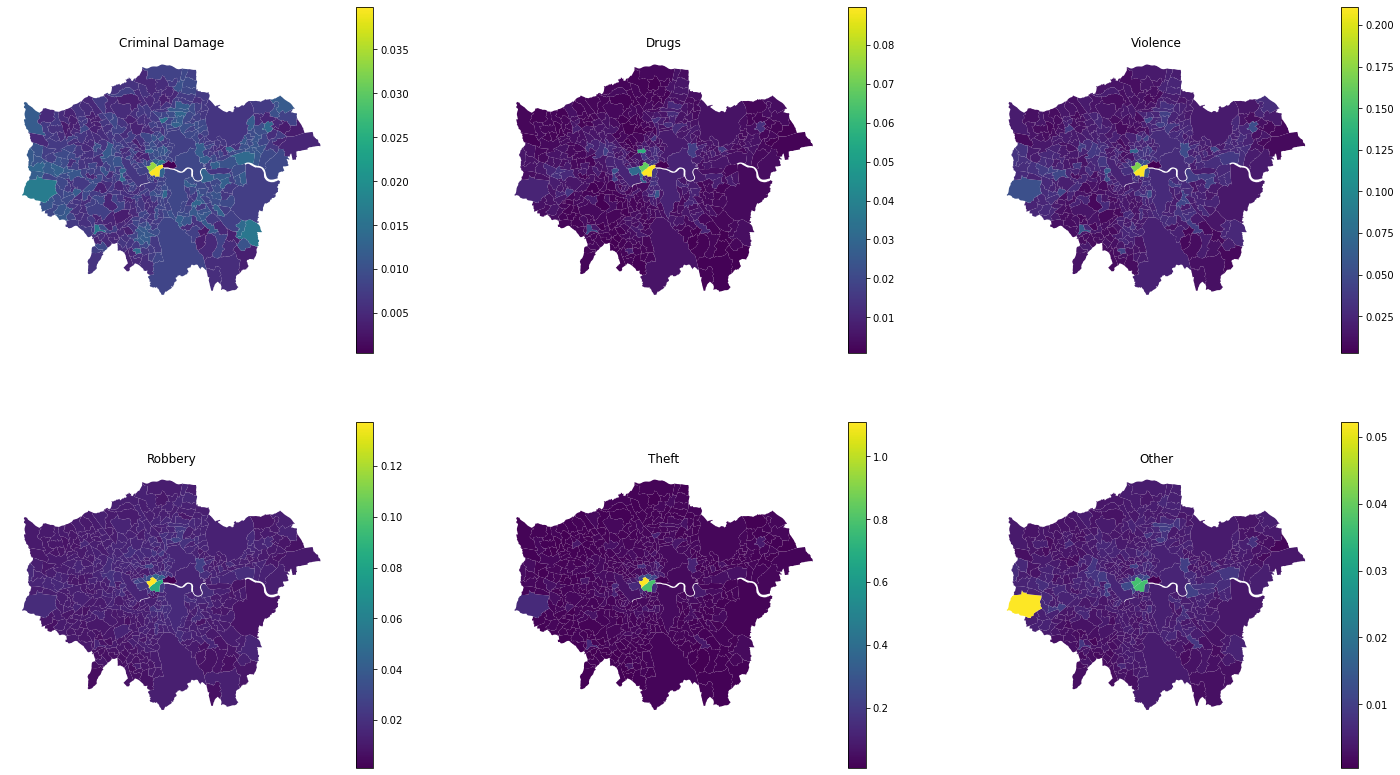

In [7]:
col = 'avg_annual_crime_rate_per_res'
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 14))
ax = ax.flatten()

ax[0].axis('off')
gdf_all[gdf_all.cat_group == "Criminal Damage"].plot(ax = ax[0], column=col, legend=True)
ax[0].set_title("Criminal Damage")

ax[1].axis('off')
gdf_all[gdf_all.cat_group == "Drugs"].plot(ax = ax[1], column=col, legend=True)
ax[1].set_title("Drugs")

ax[2].axis('off')
gdf_all[gdf_all.cat_group == "Violence"].plot(ax = ax[2], column=col, legend=True)
ax[2].set_title("Violence")

ax[3].axis('off')
gdf_all[gdf_all.cat_group == "Robbery"].plot(ax = ax[3], column=col, legend=True)
ax[3].set_title("Robbery")


ax[4].axis('off')
gdf_all[gdf_all.cat_group == "Theft"].plot(ax = ax[4], column=col, legend=True)
ax[4].set_title("Theft")


ax[5].axis('off')
gdf_all[gdf_all.cat_group == "Other"].plot(ax = ax[5], column=col, legend=True)
ax[5].set_title("Other")

plt.show()

# In unnormalized crime rates the South and East of London has the most crimes.
# However, when normalizing the rates we see most crime is focused in central west London
# One way to explain this is that more wealthy, central area attractes more crime. In other words, it is possible the 
# correlation between crime rates and house prices is likely to be positive as high house prices mean more wealth which causes more crime

In [42]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()
cur.execute("""
SELECT 
    c.year, c.cat_group, sum(c.value) as total_cases
from crime_by_year as c
join geo2 as g
on c.lsoa = g.lsoa
group by c.year, c.cat_group;
""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
result.head(2)

,year,cat_group,total_cases
0,2008,Criminal Damage,91872.0
1,2008,Drugs,68804.0


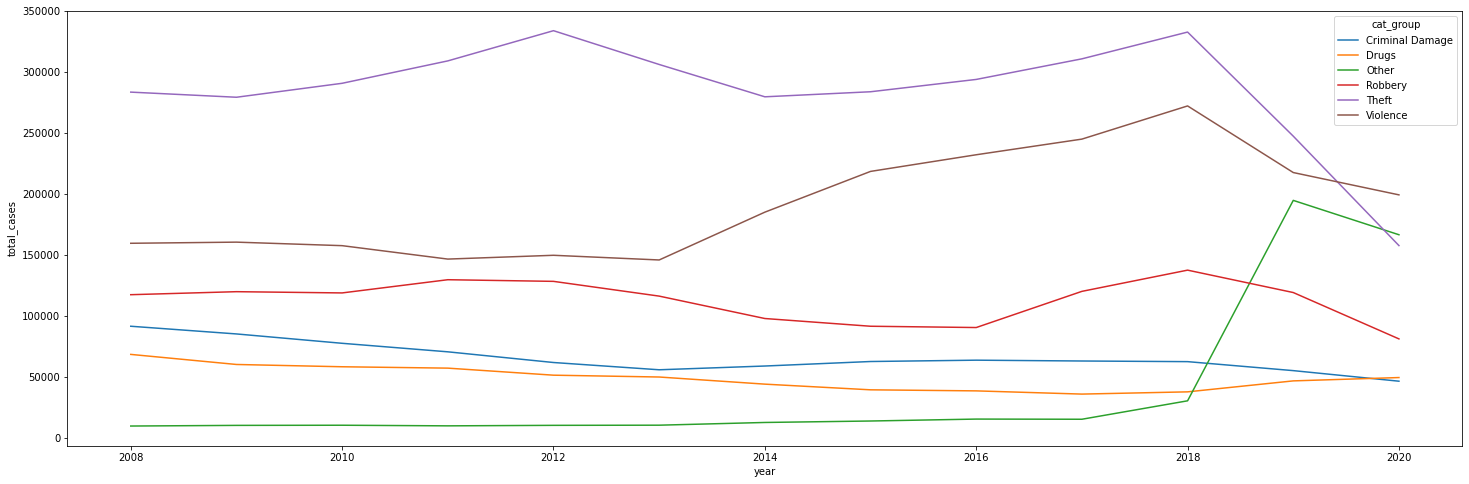

In [44]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.lineplot(data=result, x="year", y="total_cases", hue="cat_group", ax=ax)
plt.show()

# Theft is # 1 crime in London
# Robbery, Theft and violence dropped in 2020, probably due to less people on the streets caused by COVID-19
# There is a sharp increase in Other crime in 2019

In [74]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()
cur.execute("""
SELECT 
    c.year, c.cat1, c.cat2, sum(c.value) as total_cases
from crime_by_year as c
join geo2 as g
on c.lsoa = g.lsoa
where c.cat_group = 'Other'
group by c.year,c.cat1, c.cat2;

""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
result.head(2)

,year,cat1,cat2,total_cases
0,2018,Miscellaneous Crimes Against Society,Obscene Publications,165.0
1,2015,Other Notifiable Offences,Other Notifiable,13663.0


In [106]:
result = result.sort_values(by=["year", "cat1", "cat2"])
result["shift"] = result.groupby(["cat1", "cat2"])["total_cases"].shift(1)
result["perc_change"] = (result["total_cases"]/ result["shift"]) -1
result[result["shift"] > 1000].sort_values(by="perc_change", ascending=False).head(5)

# Looks like in 2019 there was 140% increase to vehicle theft crimes
# Interesting to see if it was focused on a specific area

,year,cat1,cat2,total_cases,shift,perc_change
90,2019,Public Order Offences,Public Fear Alarm or Distress,34924.0,2415.0,13.461284
115,2019,Vehicle Offences,Theft from a Motor Vehicle,78163.0,5865.0,12.327025
61,2019,Vehicle Offences,Theft or Taking of a Motor Vehicle,30039.0,2280.0,12.175000
122,2019,Vehicle Offences,Interfering with a Motor Vehicle,16512.0,1305.0,11.652874
26,2014,Other Notifiable Offences,Other Notifiable,12479.0,10229.0,0.219963


In [128]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')

sql = """
SELECT 
    c.year, c.cat1, c.cat2, concat(g.ward_name, '-', g.rg_name) as ward, g.ward_geometry, sum(c.value) as total_cases
from crime_by_year as c
join geo2 as g
on c.lsoa = g.lsoa
where c.cat_group = 'Other' and c.cat1 in ('Public Order Offences', 'Vehicle Offences')
group by c.year,c.cat1, c.cat2, concat(g.ward_name, '-', g.rg_name) , g.ward_geometry;
"""

gdf_all = gpd.read_postgis(sql, engine, geom_col='ward_geometry') 

gdf_all.head(2)

,year,cat1,cat2,ward,ward_geometry,total_cases
0,2018,Public Order Offences,"Other Offences Against the State, or Public Order",Abbey-Barking and Dagenham,"POLYGON ((543595.500 184832.800, 543601.700 18...",1.0
1,2018,Public Order Offences,"Other Offences Against the State, or Public Order",Abbey-Merton,"POLYGON ((525122.600 170480.900, 525185.400 17...",4.0


In [107]:
# gdf_all = gdf_all.sort_values(by=["year", "cat1", "cat2", "ward"])
# gdf_all["shift1"] = gdf_all.groupby(["cat1", "cat2", "ward"])["total_cases"].shift(1)
gdf_all["perc_change"] = (gdf_all["total_cases"]/ gdf_all["shift1"] ) -1
# filter by areas where prev year # of cases is around mean to avoid large increase dues to no cases in prev years
gdf_all = gdf_all[gdf_all["shift1"] > 30].sort_values(by="perc_change", ascending=False)
gdf_all.head()

,year,cat1,cat2,ward,ward_geometry,total_cases,shift1,perc_change,perc_change_bins
6799,2019,Vehicle Offences,Theft or Taking of a Motor Vehicle,Southwark-Southwark,"POLYGON ((531335.600 180529.500, 531337.700 18...",1089.0,52.0,19.942308,1000%+
6606,2019,Vehicle Offences,Theft or Taking of a Motor Vehicle,Hackney-Hackney,"POLYGON ((531928.400 187801.500, 531935.700 18...",825.0,50.0,15.500000,1000%+
5869,2019,Vehicle Offences,Interfering with a Motor Vehicle,Tower Hamlets-Tower Hamlets,"POLYGON ((533387.600 180516.400, 533389.800 18...",614.0,38.0,15.157895,1000%+
6771,2019,Vehicle Offences,Theft or Taking of a Motor Vehicle,Redbridge-Redbridge,"POLYGON ((543595.500 184832.800, 543577.100 18...",1366.0,86.0,14.883721,1000%+
4054,2019,Public Order Offences,Public Fear Alarm or Distress,Croydon-Croydon,"POLYGON ((535009.200 159504.700, 535005.500 15...",1324.0,84.0,14.761905,1000%+


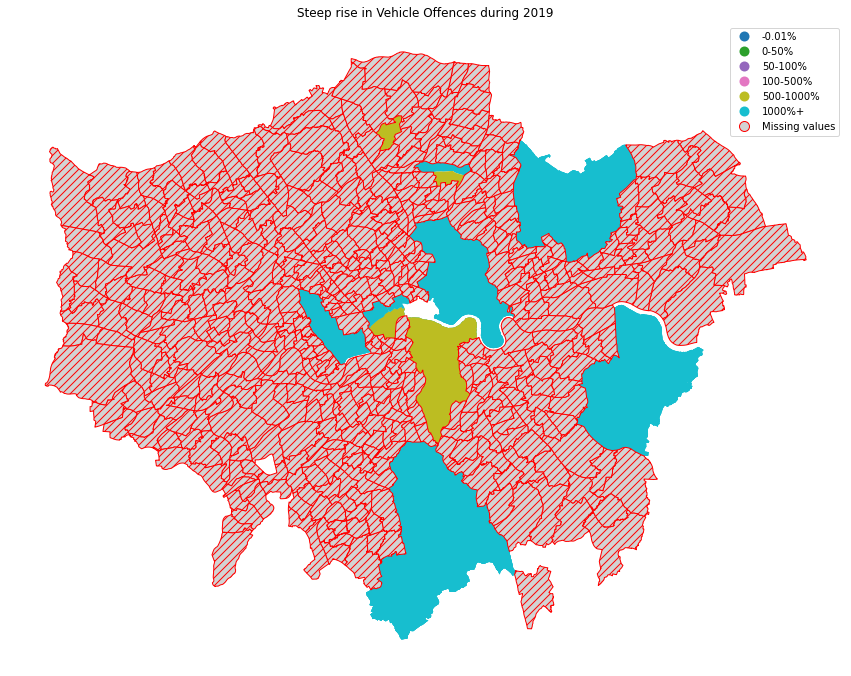

In [118]:
# Group count for better visualization
gdf_all["perc_change_bins"] = pd.cut(gdf_all["perc_change"], [-1 , 0, 0.5, 1, 5, 10, 50],labels=["-0.01%", "0-50%", "50-100%", "100-500%", "500-1000%", "1000%+"])

fig, ax = plt.subplots(figsize=(15, 14))
ax.axis('off')
# Merged back the complete geometry dataset to ensure the wards with no crime are also shown
gdf_all[["ward_geometry"]].drop_duplicates().merge(gdf_all[ (gdf_all.year == 2019)], \
                                                   how="left", on="ward_geometry").plot(ax = ax, \
                                                                                        column="perc_change_bins", legend=True, missing_kwds={"color": "lightgrey",\
                                                                                                                                            "edgecolor": "red",  \
                                                                                                                                            "hatch": "///",\
                                                                                                                                            "label": "Missing values",})
ax.set_title("Steep rise in Vehicle Offences during 2019")
plt.show()

# Grocery stores

In [149]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')

sql = """
SELECT 
    s.lsoa, g.rg_name, g.lsoa_geometry, count(distinct s.name) as total_stores
from stores as s
right join geo2 as g
on s.lsoa = g.lsoa
group by s.lsoa, g.rg_name, g.lsoa_geometry;

"""

gdf_stores = gpd.read_postgis(sql, engine, geom_col='lsoa_geometry') 
gdf_stores.head(2)

,lsoa,rg_name,lsoa_geometry,total_stores
0,E01000001,City of London,"POLYGON ((532105.092 182011.230, 532162.491 18...",1
1,E01000002,City of London,"POLYGON ((532746.813 181786.891, 532671.688 18...",1


/home/elena/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:373: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


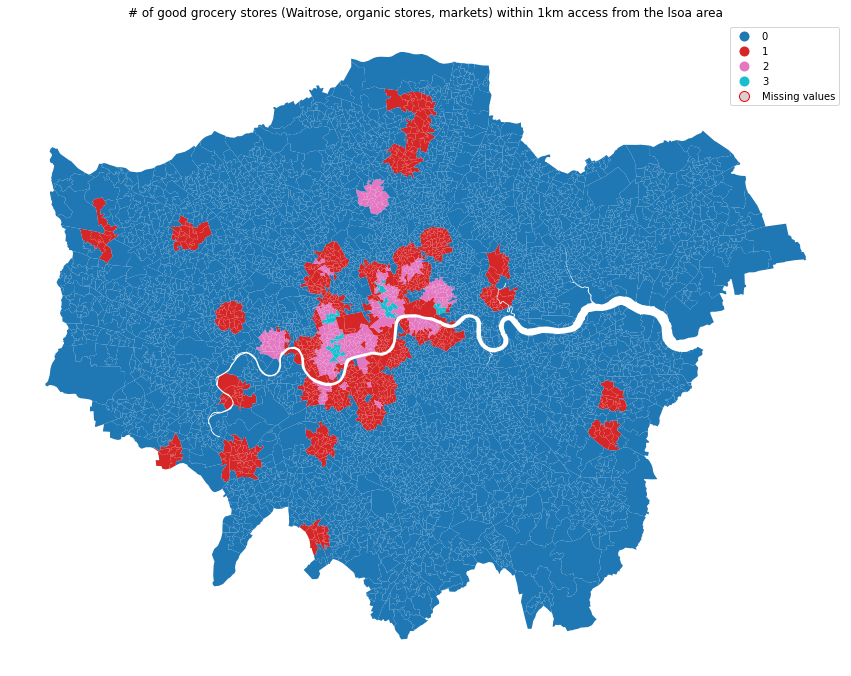

In [156]:
# Group count for better visualization
gdf_stores["total_stores_bins"] = [str(x) if pd.isna(x) == False else x for x in gdf_stores["total_stores"]]

fig, ax = plt.subplots(figsize=(15, 14))
ax.axis('off')
# Merged back the complete geometry dataset to ensure the wards with no crime are also shown
gdf_stores.plot(ax = ax, column="total_stores_bins", legend=True, missing_kwds={"color": "lightgrey","edgecolor": "red", "hatch": "///", "label": "Missing values",})
ax.set_title("# of good grocery stores (Waitrose, organic stores, markets) within 1km access from the lsoa area")
plt.show()

# Schools

In [191]:
# Schools breakdown by gender and phase

engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()
cur.execute("""
SELECT 
    s.gender, s.phase, count( distinct s.school_nam) as total_schools
from schools as s
where s.type in ('Community School', 'Academy Sponsor Led', 'Academy Converter',
       'Voluntary Controlled School',
       'Free Schools', 'Foundation School', 'University Technical College',
       'Academy Alternative Provision Sponsor Led',
       'Academy Alternative Provision Converter',
       'City Technology College', 
       'Free Schools - Alternative Provision',
       'Academy Special Sponsor Led', 'Studio Schools')
and s.phase in ('Primary', 'Secondary', 'All Through')
group by s.gender, s.phase;

""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
pd.pivot_table(result, index="gender", columns="phase")

total_schools                  
phase    All Through Primary Secondary
gender                                
Boys             NaN     1.0      41.0
Girls            NaN     1.0      63.0
Mixed           37.0  1484.0     318.0

In [184]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')

sql = """
SELECT 
    s.lsoa, s.gender, s.phase, g.rg_name, g.lsoa_geometry, count( distinct s.school_nam) as total_schools
from schools as s
right join geo2 as g
on s.lsoa = g.lsoa
where s.type in ('Community School', 'Academy Sponsor Led', 'Academy Converter',
       'Voluntary Controlled School',
       'Free Schools', 'Foundation School', 'University Technical College',
       'Academy Alternative Provision Sponsor Led',
       'Academy Alternative Provision Converter',
       'City Technology College', 
       'Free Schools - Alternative Provision',
       'Academy Special Sponsor Led', 'Studio Schools')
and s.phase in ('Primary', 'Secondary', 'All Through')
group by s.lsoa, s.gender, s.phase, g.rg_name, g.lsoa_geometry
;

"""

gdf_all = gpd.read_postgis(sql, engine, geom_col='lsoa_geometry') 
gdf_all.head(2)

# Excluding special schools

,lsoa,gender,phase,rg_name,lsoa_geometry,total_schools
0,E01000001,Mixed,Primary,City of London,"POLYGON ((532105.092 182011.230, 532162.491 18...",1
1,E01000002,Mixed,Primary,City of London,"POLYGON ((532746.813 181786.891, 532671.688 18...",1


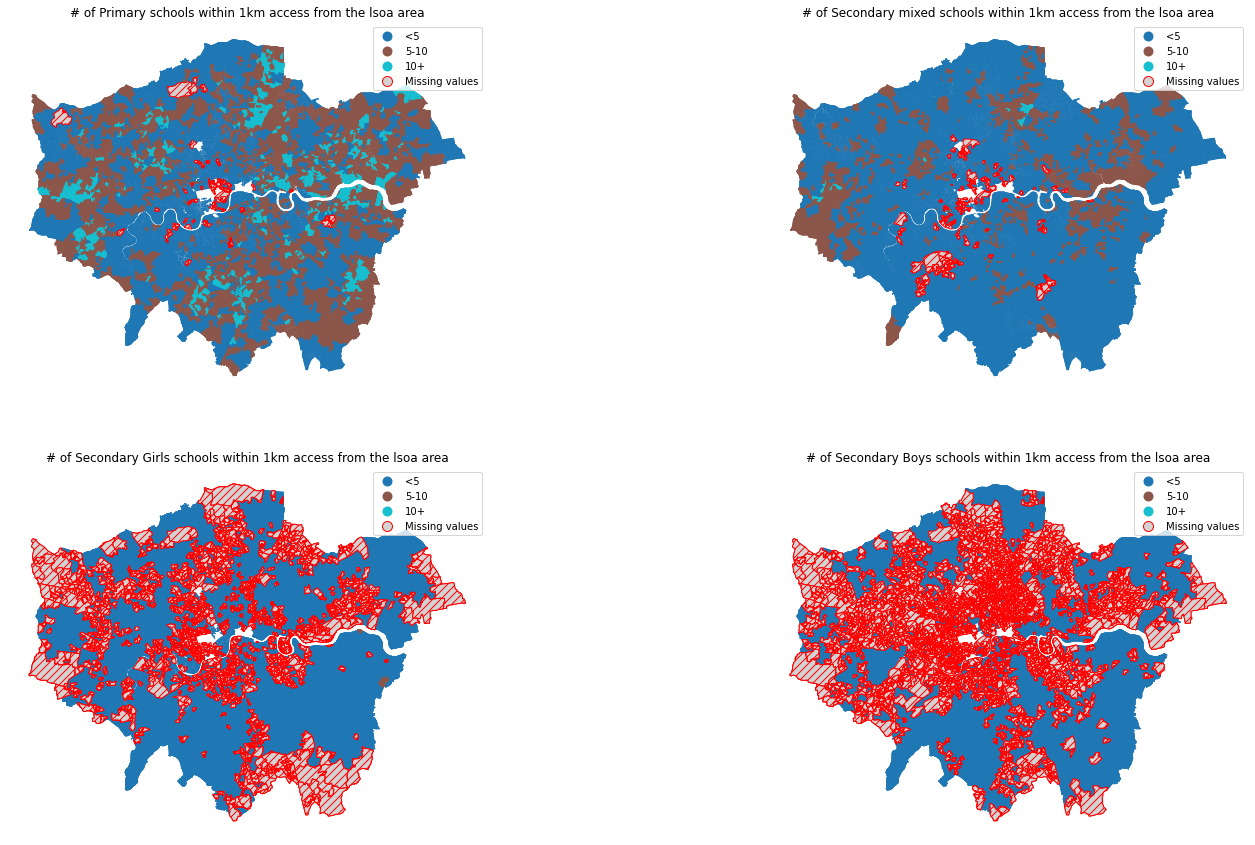

In [202]:
gdf_all["total_schools_bins"] = pd.cut(gdf_all["total_schools"], [0, 5, 10, 25],labels=["<5", "5-10",  "10+"])

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(25, 15))
ax = ax.flatten()

ax[0].axis('off')
gdf_all[["lsoa_geometry"]].merge(gdf_all[gdf_all.phase == "Primary"], how="left", on="lsoa_geometry").plot(ax = ax[0],\
                                                                                                         column="total_schools_bins",\
                                                                                                         legend=True, \
                                                                                                         missing_kwds={"color": "lightgrey","edgecolor": "red", "hatch": "///", "label": "Missing values",})
ax[0].set_title("# of Primary schools within 1km access from the lsoa area")


ax[1].axis('off')
gdf_all[["lsoa_geometry"]].merge(gdf_all[ (gdf_all.phase == "Secondary") & (gdf_all.gender == "Mixed")], \
                               how="left", \
                               on="lsoa_geometry").plot(ax = ax[1], \
                                                        column="total_schools_bins", \
                                                        legend=True, \
                                                        missing_kwds={"color": "lightgrey","edgecolor": "red", "hatch": "///", "label": "Missing values",})
ax[1].set_title("# of Secondary mixed schools within 1km access from the lsoa area")


ax[2].axis('off')
gdf_all[["lsoa_geometry"]].merge(gdf_all[ (gdf_all.phase == "Secondary") & (gdf_all.gender == "Girls")], \
                               how="left", on="lsoa_geometry").plot(ax = ax[2], \
                                                                    column="total_schools_bins",\
                                                                    legend=True, \
                                                                    missing_kwds={"color": "lightgrey","edgecolor": "red", "hatch": "///", "label": "Missing values",})
ax[2].set_title("# of Secondary Girls schools within 1km access from the lsoa area")


ax[3].axis('off')
gdf_all[["lsoa_geometry"]].merge(gdf_all[ (gdf_all.phase == "Secondary") & (gdf_all.gender == "Boys")], \
                               how="left", \
                               on="lsoa_geometry").plot(ax = ax[3], column="total_schools_bins", \
                                                        legend=True, \
                                                        missing_kwds={"color": "lightgrey","edgecolor": "red", "hatch": "///", "label": "Missing values",})
ax[3].set_title("# of Secondary Boys schools within 1km access from the lsoa area")

plt.show()

# Food

In [204]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')

sql = """
SELECT 
    f.lsoa, g.rg_name, g.lsoa_geometry, count( distinct f.name) as total_venues
from food as f
right join geo2 as g
on f.lsoa = g.lsoa
group by f.lsoa, g.rg_name, g.lsoa_geometry;

"""

gdf_all = gpd.read_postgis(sql, engine, geom_col='lsoa_geometry') 
gdf_all.head(2)

,lsoa,rg_name,lsoa_geometry,total_venues
0,E01000001,City of London,"POLYGON ((532105.092 182011.230, 532162.491 18...",42
1,E01000002,City of London,"POLYGON ((532746.813 181786.891, 532671.688 18...",44


In [205]:
gdf_all.describe()

,total_venues
count,4835.000000
mean,41.864116
std,10.292914
min,0.000000
25%,42.000000
50%,46.000000
75%,48.000000
max,50.000000


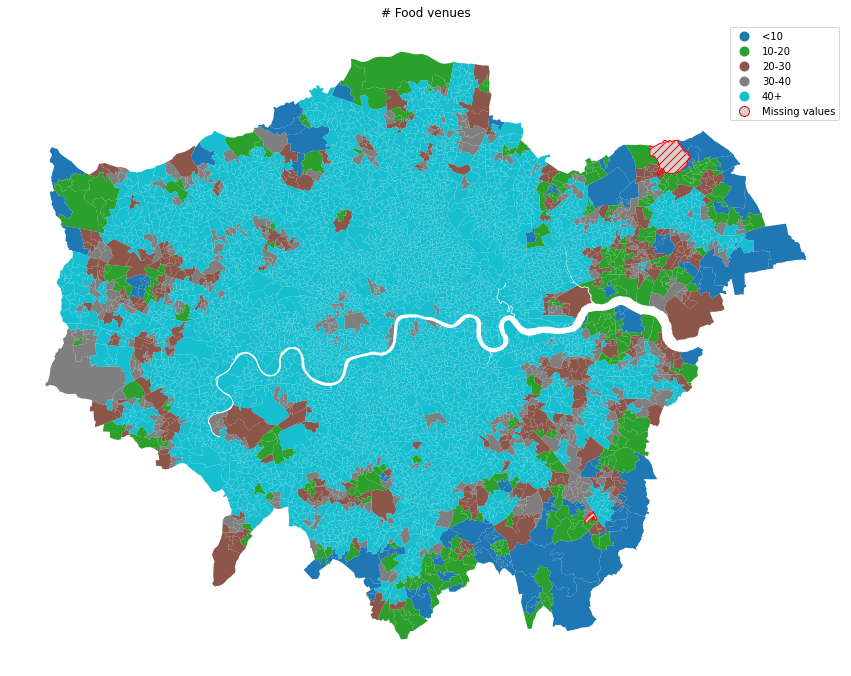

In [208]:
gdf_all["total_venues_bins"] = pd.cut(gdf_all["total_venues"], [0, 10, 20, 30, 40, 50],labels=["<10", "10-20", "20-30", "30-40", "40+"])

fig, ax = plt.subplots(figsize=(15, 14))
ax.axis('off')
# Merged back the complete geometry dataset to ensure the wards with no crime are also shown
gdf_all.plot(ax = ax, column="total_venues_bins", legend=True, missing_kwds={"color": "lightgrey","edgecolor": "red", "hatch": "///", "label": "Missing values",})
ax.set_title("# Food venues")
plt.show()

In [ ]:
# Most areas in London have a good access to restaurants and pubs (within 1km)
# Majority of lsoa areas have 40+ venues available
# Now let's break it down by type of venue

In [216]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')

sql = """
SELECT
    ward_name, l2, rg_name, ward_geometry, avg(total_venues) as total_venues
    from
(SELECT 
    f.lsoa, g.ward_name, g.ward_geometry, f.l2, g.rg_name, count( distinct f.name) as total_venues
from food as f
right join geo2 as g
on f.lsoa = g.lsoa
where f.l2 in ('Bar', 'Café', 'Coffee Shop', 'Bakery', 'Asian Restaurant', 'Indian Restaurant', 'French Restaurant')
group by f.lsoa, g.ward_name, g.ward_geometry, f.l2, g.rg_name) as t

group by ward_name, l2, rg_name, ward_geometry
;

"""

gdf_food = gpd.read_postgis(sql, engine, geom_col='ward_geometry') 
gdf_food.head(2)

,ward_name,l2,rg_name,ward_geometry,total_venues
0,Abbey,Asian Restaurant,Barking and Dagenham,"POLYGON ((543595.500 184832.800, 543601.700 18...",5.142857
1,Abbey,Asian Restaurant,Merton,"POLYGON ((525122.600 170480.900, 525185.400 17...",4.833333


/home/elena/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:373: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/elena/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:373: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/elena/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:373: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


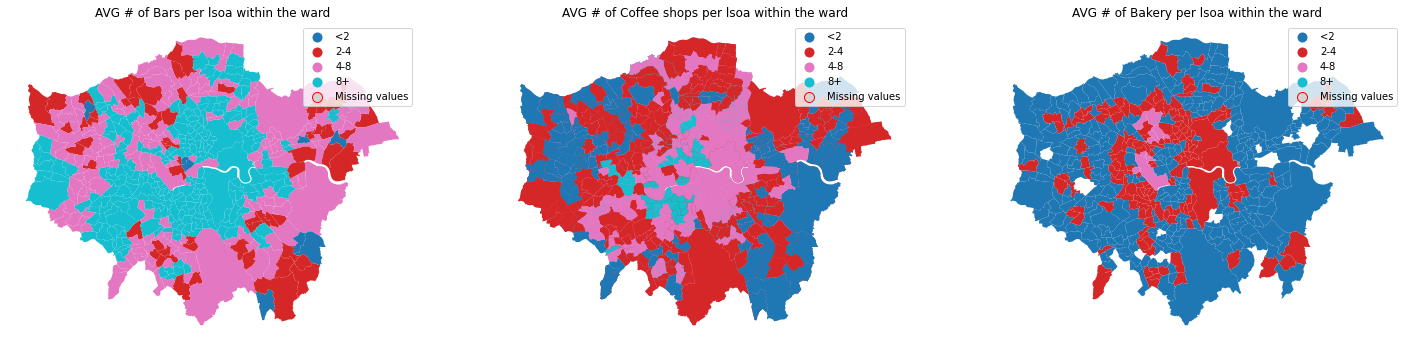

In [222]:
gdf_food["total_venues_bins"] = pd.cut(gdf_food["total_venues"], [0, 2, 4, 7, 50],labels=["<2", "2-4", "4-8", "8+"])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 8))

ax[0].axis('off')
gdf_food[gdf_food.l2 == 'Bar'].plot(ax = ax[0], column="total_venues_bins", legend=True, missing_kwds={"color": "lightgrey","edgecolor": "red", "hatch": "///", "label": "Missing values",})
ax[0].set_title("AVG # of Bars per lsoa within the ward")


ax[1].axis('off')
gdf_food[gdf_food.l2.isin(['Coffee Shop', 'Café'])].plot(ax = ax[1], column="total_venues_bins", legend=True, missing_kwds={"color": "lightgrey","edgecolor": "red", "hatch": "///", "label": "Missing values",})
ax[1].set_title("AVG # of Coffee shops per lsoa within the ward")


ax[2].axis('off')
gdf_food[gdf_food.l2.isin(['Bakery'])].plot(ax = ax[2], column="total_venues_bins", legend=True, missing_kwds={"color": "lightgrey","edgecolor": "red", "hatch": "///", "label": "Missing values",})
ax[2].set_title("AVG # of Bakery per lsoa within the ward")

plt.show()

/home/elena/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:373: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/elena/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:373: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


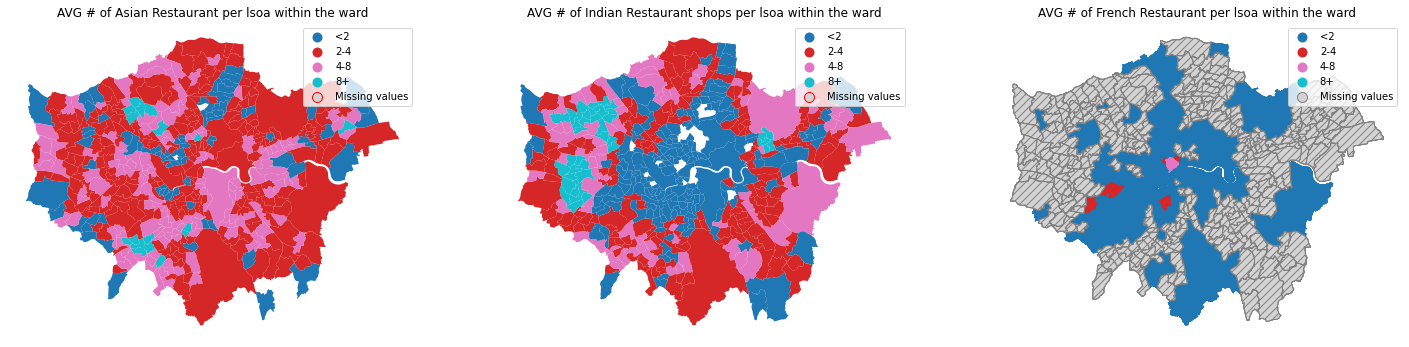

In [225]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 8))

ax[0].axis('off')
gdf_food[gdf_food.l2 == 'Asian Restaurant'].plot(ax = ax[0], column="total_venues_bins", legend=True, missing_kwds={"color": "lightgrey","edgecolor": "red", "hatch": "///", "label": "Missing values",})
ax[0].set_title("AVG # of Asian Restaurant per lsoa within the ward")


ax[1].axis('off')
gdf_food[gdf_food.l2.isin(['Indian Restaurant'])].plot(ax = ax[1], column="total_venues_bins", legend=True, missing_kwds={"color": "lightgrey","edgecolor": "red", "hatch": "///", "label": "Missing values",})
ax[1].set_title("AVG # of Indian Restaurant shops per lsoa within the ward")


ax[2].axis('off')
gdf_food[["ward_geometry"]].merge(gdf_food[gdf_food.l2.isin(['French Restaurant'])], how="left", on="ward_geometry").plot(ax = ax[2], column="total_venues_bins", legend=True, missing_kwds={"color": "lightgrey","edgecolor": "grey", "hatch": "///", "label": "Missing values",})
ax[2].set_title("AVG # of French Restaurant per lsoa within the ward")

plt.show()

In [ ]:
# Asian restaurants are popular in all areas of London
# Indian (most likely indian take aways) are more prevailing in the outskirts of the city
# French restaurants are more rare and most are located in Marylebone (French neighborhood)

In [229]:
gdf_food[gdf_food.l2.isin(['French Restaurant'])].sort_values(by="total_venues", ascending=False).head()

,ward_name,l2,rg_name,ward_geometry,total_venues,total_venues_bins
2898,West End,French Restaurant,Westminster,"POLYGON ((529928.500 181049.000, 529921.300 18...",5.166667,4-8
1794,Marylebone High Street,French Restaurant,Westminster,"POLYGON ((528633.100 182307.600, 528728.200 18...",4.666667,4-8
323,Bryanston and Dorset Square,French Restaurant,Westminster,"POLYGON ((527921.900 181967.000, 527966.700 18...",3.428571,2-4
1538,Isleworth,French Restaurant,Hounslow,"POLYGON ((516743.200 175385.300, 516677.500 17...",2.666667,2-4
2272,Shaftesbury,French Restaurant,Wandsworth,"POLYGON ((528639.000 175215.200, 528588.700 17...",2.500000,2-4


# Schools

In [4]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()
cur.execute("""

SELECT * from schools;

""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
result.head(2)

,school_nam,phase,type,address,postcode,status,gender,age,weblink,longt,lat,lsoa,total,pupil_count,dist,urn
0,Sir John Cass's Foundation Primary School,Primary,Voluntary Aided School,St James's Passage,EC3A 5DE,Open,Mixed,3 - 11,www.sirjohncassprimary.org,-0.077504,51.51397,E01004292,64.0,7.0,None,100000.0
1,Sir John Cass's Foundation Primary School,Primary,Voluntary Aided School,St James's Passage,EC3A 5DE,Open,Mixed,3 - 11,www.sirjohncassprimary.org,-0.077504,51.51397,E01004325,120.0,3.0,None,100000.0


In [43]:
from fuzzywuzzy import fuzz
s = "St Paul's Girls' School"



In [42]:
mapping = {"top_name": [], "db_name": [], "score": []}
for j in top_schools["name"]:
    score = 0
    name = ""
    for i in result["school_nam"].unique():
        my_score = fuzz.token_sort_ratio(i, j)
        if my_score > score:
            score = my_score
            name = i
            
    mapping["top_name"].append(name)
    mapping["db_name"].append(j)
    mapping["score"].append(score)

df_mapping = pd.DataFrame(mapping)

In [28]:
# https://www.mylondon.news/news/zone-1-news/best-london-secondary-schools-ranked-18596220


list_of_top10_schools = ["Wembley High Technology College", "Wilson's School", "Queen Elizabeth's School", "Wallington County Grammar School", \
                        "Woodford County High School", "Mossbourne Community Academy", "The Tiffin Girls' School", "Nonsuch High School for Girls", \
                        "Sacred Heart Catholic School", "Wallington High School for Girls"]

In [46]:
top_schools.head(30)

,A_grades_perc,name
0,99.60,St Paul's Girls' School
1,98.61,Westminster School
2,97.60,Wycombe Abbey School
3,97.27,Guildford High School for Girls
4,96.66,St Paul's School
5,96.29,North London Collegiate School
6,96.12,Godolphin & Latymer School
7,95.88,King's College School - Wimbledon
8,94.97,St Mary's School - Ascot
9,94.62,City of London School for Boys


In [44]:
df_mapping

,top_name,db_name,score
0,St Paul's Girls' School,St Paul's Girls' School,100
1,Westminster School,Westminster School,100
2,Wyborne Primary School,Wycombe Abbey School,67
3,Islamia School for Girls',Guildford High School for Girls,73
4,St Paul's School,St Paul's School,100
...,...,...,...
95,Croydon High School,Croydon High School GDST,88
96,Cleves School,Reed's School,77
97,Nonsuch High School for Girls,Manchester High School for Girls,82
98,Devonshire Primary School,"Maynard School, Devon",71


In [27]:
# Get top schools from the below rating site
# https://www.best-schools.co.uk/uk-school-league-tables/list-of-league-tables/top-100-schools-by-gcse

import requests
from bs4 import BeautifulSoup

path = 'https://www.best-schools.co.uk/uk-school-league-tables/list-of-league-tables/top-100-schools-by-gcse'
r = requests.get(path)
soup = BeautifulSoup(r.text, 'html.parser')

my_dict = {"A_grades_perc" : [], "name": []}
for i in soup.find('tbody').find_all("tr"):
    my_dict["A_grades_perc"].append(i.find_all("td")[1].text)
    my_dict["name"].append(i.find_all("td")[2].text)
top_schools = pd.DataFrame(my_dict)
top_schools.head(2)

,A_grades_perc,name
0,99.60,St Paul's Girls' School
1,98.61,Westminster School


In [58]:
def applyTopSchoolTag(row):
    if row in list_of_top10_schools or row in top_schools["name"].values:
        return "Y"
    else:
        return "N"
        

result["top_rated"] = result["school_nam"].apply(applyTopSchoolTag)

In [59]:
result.groupby([ "top_rated"]).agg({"school_nam": "nunique"})

,school_nam
top_rated,
N,3086
Y,32


In [60]:
result[result.top_rated == "Y"]["school_nam"].unique()

array(['Wembley High Technology College', 'Woodford County High School',
       'Mossbourne Community Academy', "The Tiffin Girls' School",
       "Wilson's School", 'Wallington High School for Girls',
       'Nonsuch High School for Girls',
       'Wallington County Grammar School', 'Sacred Heart Catholic School',
       'City of London School for Girls', 'University College School',
       'South Hampstead High School', "St Paul's Girls' School",
       'Latymer Upper School', "St James Senior Girls' School",
       'Dulwich College', "James Allen's Girls' School",
       'Ibstock Place School', 'Putney High School', 'Eltham College',
       'Whitgift School', 'Old Palace of John Whitgift School',
       'Notting Hill and Ealing High School', 'Palmers Green High School',
       'Channing School', 'Highgate School',
       'North London Collegiate School', 'Wimbledon High School',
       "St Paul's School", 'Hampton School', 'Westminster School',
       'Kingston Grammar School'], dty

In [56]:
result[result.school_nam == "Westminster School"]["school_nam"].iloc[0]

'Westminster School'

In [57]:
top_schools[top_schools.name == "Westminster School"]

,A_grades_perc,name
1,98.61,Westminster School


In [ ]:
# # Get Data from AWS RDS PostgresSQL DB (all data within the database is publicly available and been scrapped and collected by myself)

# engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
# cur = engine.cursor()

# cur.execute("""

# SELECT 
#     CAST (p.year AS INTEGER), p.new, p.duration, p.type, g.rg_name, g.geometry,
#     CAST(ROUND(AVG(p.price)::numeric,0 ) as integer) as avg_price,
#     CAST(ROUND(AVG(e.total_floor_area)::numeric,0 ) as integer) as avg_sqft,
#     CAST(ROUND(AVG(e.number_habitable_rooms)::numeric,0 ) as integer) as avg_rooms,
#     CAST(ROUND( AVG(p.price/e.total_floor_area)::numeric, 3 ) as integer) as sqft_price,
#     CAST(ROUND( AVG(p.price/e.number_habitable_rooms)::numeric, 3 ) as integer) as price_per_room

# from prices as p
# join epc as e
# on e.brn = p.brn
# join geo as g
# on p.lsoa = g.lsoa
# where e.total_floor_area <> 0 and e.number_habitable_rooms <> 0 and e.number_habitable_rooms is not null and e.total_floor_area is not null

# group by p.year, p.new, p.duration, p.type, g.rg_name, g.geometry;

# """)
# rows = cur.fetchall()
# result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
# result.head(2)